# Data Analysis from Physical Phone Experiments - 6BBR06

## Introduction

Welcome to our  ...........

## Task 1: Step Frequency from Walking Data

The first task is... summary 

1. Importing and plotting the relevant data
2. Pace estimation
3. Plot of acceleration magnitude vs time with the detected peaks
4. Plot of acceleration magnitude vs time with the detected peaks for different datasets
5. Fourier transforms and comparison with manuel peak detection

The relevant attached files for this task are:
- Versnelling_walking.csv
- Versnelling_running.csv
- Versnelling_steps.csv

#### 1.0 Importing all relevant python librabies

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

#### 1.1 Importing and plotting the data

After importing the required libraries we start with importing the data and plotting it. We do this to get a good view and to decide if the data is valid and later to decide on a interval ...........

['CBL programming.ipynb', 'Lift_0_2_3_4_6.csv', 'Versnelling_walking.csv']


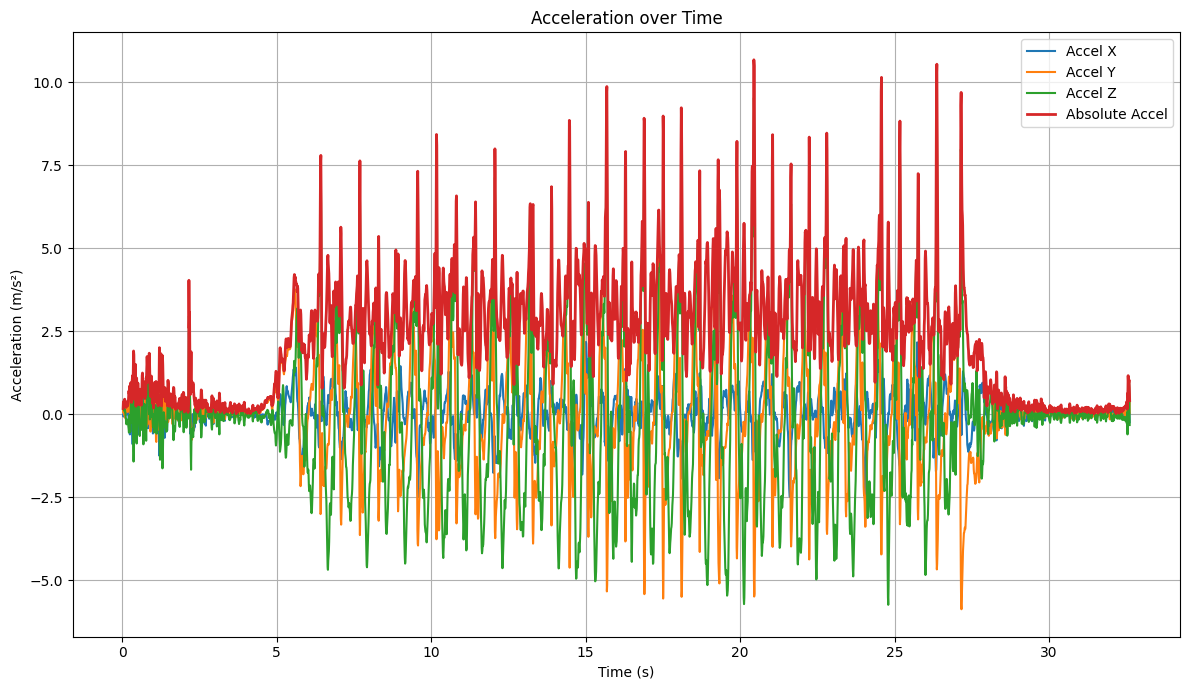

In [18]:
# Importing data and putting it in a pandas dataframe
folder_path = r"C:\Users\fvfko\OneDrive\Bureaublad\CBL programming" 
os.chdir(f"{folder_path}")
print(os.listdir())
file_path = "Versnelling_walking.csv"

df = pd.read_csv(
    file_path,
    sep=",",
    decimal=","
)

# Plot the data from the pandas dataframe
plt.figure(figsize=(12, 7))

plt.plot(df["Time (s)"], df["Linear Acceleration x (m/s^2)"], label="Accel X")
plt.plot(df["Time (s)"], df["Linear Acceleration y (m/s^2)"], label="Accel Y")
plt.plot(df["Time (s)"], df["Linear Acceleration z (m/s^2)"], label="Accel Z")
plt.plot(
    df["Time (s)"],
    df["Absolute acceleration (m/s^2)"],
    label="Absolute Accel",
    linewidth=2
)

plt.autoscale(enable=True, axis="both", tight=False) # To ensure a perfect fit 

plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration over Time")
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

#### 1.2 Pace estimation
Before we do the pace estimation we have to select an appropriate interval for analysis (1), do a preliminary estimation for pace (2) and decide whether we need a particular acceleration direction or use the total acceleration magnitude (3) .

1. Based on the plot above we select the time interval from 15 seconds untill 20 seconds. During this interval the walking pace was most steady. Every other interval would be valid 

2. The average walking speed is between 4 and 6 km/h and the average step length is between 70 and 90 cm. With a speed of 5 km/h and a step length of 90 cm,  We estimate that we walked at a normal pace of 5 km/h, we estimate the walking frequency to be: ....

3. We need the total acceleration magnitude because we didn't walk in a particular direction so we need to take more than one dimension into account.

Once we have that out of the way, we can starting writing code to estimate the pace. We used the following method: each big acceleration peak (absolute acceleration) equals one step. The problem is: there are a lot of peaks, some small some big. To get a valid estimate of the amount of steps we took, we have to filter the biggest peaks that in reality correspond to the steps. 
Our method:
- Within this interval, the absolute acceleration magnitude was computed from the three acceleration components using: amag = sqrt(ax^2 + ay^2 + az^2). This magnitude signal is used for peak detection because it combines the contributions of all three axes and is less sensitive to sensor orientation.
- Step detection was primarily based on the height of the peaks. Only peaks whose magnitude exceeded a threshold — defined as the mean acceleration plus a fraction of its standard deviation — were considered as potential steps. This ensures that small fluctuations and noise are ignored.
- In addition, a minimum time distance between consecutive peaks was applied as a secondary check. Based on typical human walking cadence (0.3–0.6 seconds per step), we enforced a minimum interval of approximately 0.4 seconds between peaks to prevent counting multiple peaks from a single step.
- The number of detected peaks that met these criteria corresponds to the estimated number of steps in the selected interval.

In [19]:
t_start = 15.0
t_end = 20.0

selected = df[ # Create the interval in the data
    (df["Time (s)"] >= t_start) &
    (df["Time (s)"] <= t_end)
].copy() 

selected["amag"] = np.sqrt(
   selected["Linear Acceleration x (m/s^2)"]**2 +
   selected["Linear Acceleration y (m/s^2)"]**2 +
   selected["Linear Acceleration z (m/s^2)"]**2
)


t = selected["Time (s)"].values
amag = selected["amag"].values


sampling_rate = 1 / np.mean(np.diff(t))  # in Hz


min_distance_sec = 0.4  # minimum interval between peaks (~0.5 s) (humans walk 0.5–1.0 s per step)
min_distance_samples = int(min_distance_sec * sampling_rate)




peaks, properties = find_peaks(
   amag,
   distance=min_distance_samples,
   height=np.mean(amag) + 0.2 * np.std(amag) # To avoid height small fluctuations
)


step_times = t[peaks]
n_steps = len(peaks) # amount of steps


duration = t[-1] - t[0]  # duration of selected interval
step_frequency_hz = n_steps / duration
step_frequency_spm = step_frequency_hz * 60  # steps per minute
step_length = 1 # Taking 1 meter per step
velocity = (1*n_steps) / duration

print(f"Interval start: {t_start}, interval end: {t_end}")
print(f"Interval duration: {duration:.2f} s")
print(f"Steps: {n_steps} ")
print(f"Step frequency: {step_frequency_hz:.2f} Hz")
print(f"Steps per minute: {step_frequency_spm:.0f} steps/min, ({(velocity *3.6):.2f} km/h)")

Interval start: 15.0, interval end: 20.0
Interval duration: 4.99 s
Steps: 9 
Step frequency: 1.80 Hz
Steps per minute: 108 steps/min, (6.50 km/h)


#### 1.3: Acceleration magnitude vs time with the detected peaks

We did the pace estimation and now it is time to plot the acceleration magnitude versus time with the detected peaks over our selected time interval. All peaks that were selected as steps will be highlighted over the chosen interval. We will create these plots using mulitple data sets. Sets where we were running and walking up steps:


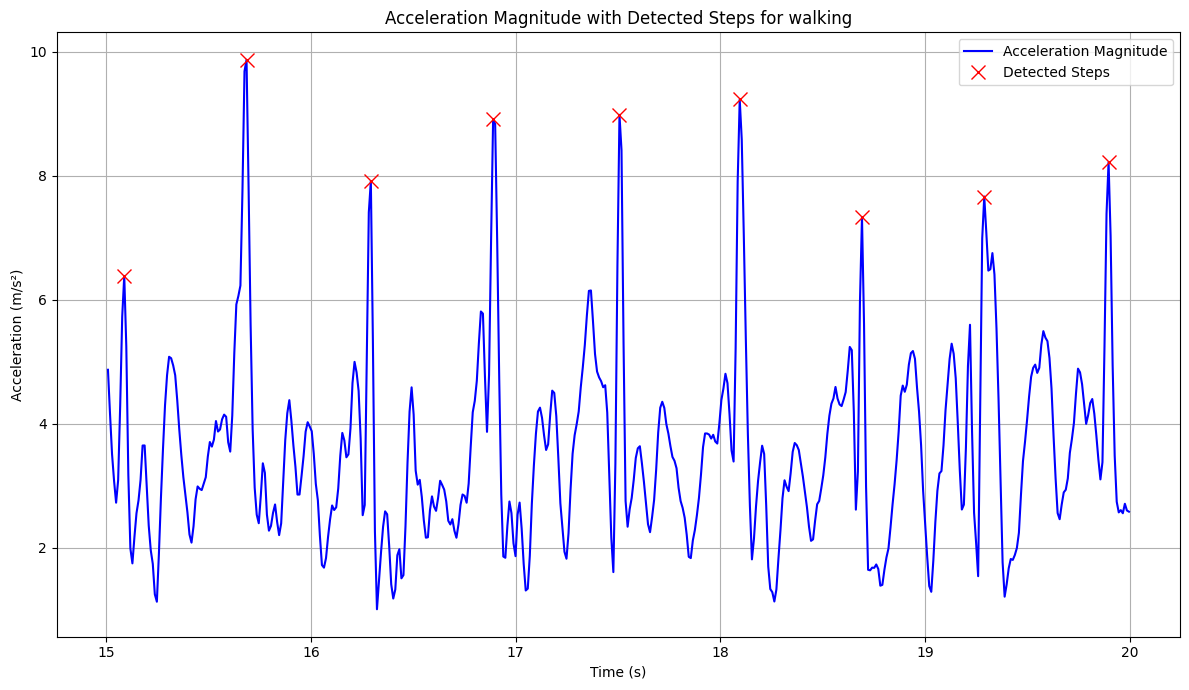

In [20]:
plt.figure(figsize=(12, 7))


plt.plot(t, amag, label="Acceleration Magnitude", color='blue')
plt.plot(step_times, amag[peaks], 'rx', label="Detected Steps", markersize=10)  # Mark peaks


plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration Magnitude with Detected Steps for walking")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1.4 Plot of acceleration magnitude vs time with the detected peaks for different datasets
To check the plot of acceleration magnitude vs time with the detected peaks for different datasets, for example, one where we were running or walking up stairs, we copy the code and use the other data file in the directory. The only thing that we have to change is the data file where the script gets its data from.

Files in folder: ['CBL programming.ipynb', 'Lift_0_2_3_4_6.csv', 'Versnelling_walking.csv']


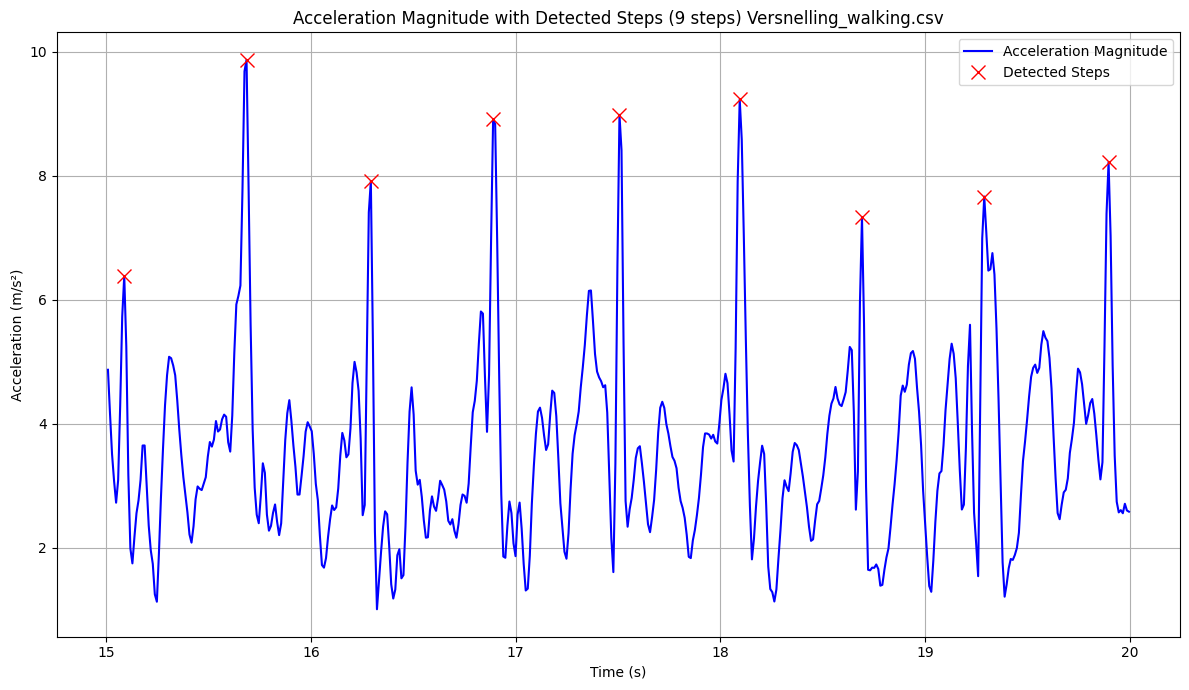

File: Versnelling_walking.csv
Interval start: 15.0, interval end: 20.0
Interval duration: 4.99 s
Steps: 9 
Step frequency: 1.80 Hz
Steps: 108 steps/min, 6.50 km/h)

Files in folder: ['CBL programming.ipynb', 'Lift_0_2_3_4_6.csv', 'Versnelling_walking.csv']


FileNotFoundError: [Errno 2] No such file or directory: 'Versnelling_running.csv'

In [21]:
def plot_acceleration_steps(t_start, t_end, folder_path, file_path):
    os.chdir(folder_path)
    print("Files in folder:", os.listdir())
    
    # Load CSV
    df = pd.read_csv(file_path, sep=",", decimal=",")
    
    # Create nterval
    selected = df[(df["Time (s)"] >= t_start) & (df["Time (s)"] <= t_end)].copy()
    
    # Compute acceleration magnitude
    selected["amag"] = np.sqrt(
        selected["Linear Acceleration x (m/s^2)"]**2 +
        selected["Linear Acceleration y (m/s^2)"]**2 +
        selected["Linear Acceleration z (m/s^2)"]**2
    )
    
    t = selected["Time (s)"].values
    amag = selected["amag"].values
    
    # Sampling rate
    sampling_rate = 1 / np.mean(np.diff(t))  # in Hz
    
    # Minimum distance between peaks
    min_distance_sec = 0.4  # humans walk 0.5–1.0 s per step
    min_distance_samples = int(min_distance_sec * sampling_rate)
    
    # Find peaks
    peaks, properties = find_peaks(
        amag,
        distance=min_distance_samples,
        height=np.mean(amag) + 0.2 * np.std(amag)
    )
    
    step_times = t[peaks]
    n_steps = len(peaks)
    
    # Plot
    plt.figure(figsize=(12, 7))
    plt.plot(t, amag, label="Acceleration Magnitude", color='blue')
    plt.plot(step_times, amag[peaks], 'rx', label="Detected Steps", markersize=10)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"Acceleration Magnitude with Detected Steps ({n_steps} steps) {file_path}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print step info
    duration = t[-1] - t[0]
    step_frequency_hz = n_steps / duration
    step_frequency_spm = step_frequency_hz * 60  # steps per minute
    step_length = 1  # assume 1 m per step
    velocity = (step_length * n_steps) / duration
    print(f"File: {file_path}")
    print(f"Interval start: {t_start}, interval end: {t_end}")
    print(f"Interval duration: {duration:.2f} s")
    print(f"Steps: {n_steps} ")
    print(f"Step frequency: {step_frequency_hz:.2f} Hz")
    print(f"Steps: {step_frequency_spm:.0f} steps/min, {(velocity *3.6):.2f} km/h)\n")

# Parameters
folder_path = r"C:\Users\fvfko\OneDrive\Bureaublad\CBL programming"  
file_path_list = ["Versnelling_walking.csv", "Versnelling_running.csv", "Versnelling_stairs.csv"] # All data sets
t_start = 15.0
t_end = 20.0

# Run
for file_path in file_path_list:
    file_path = file_path
    plot_acceleration_steps(t_start, t_end, folder_path, file_path)

When walking, the body moves gently and steadily. The acceleration peaks are few, evenly spaced, and reflect a calm, regular rhythm. Running is faster and more intense: peaks are taller, closer together, and appear more frequently, showing the quick, energetic steps. Climbing stairs tells a different story—peaks are uneven and irregular, reflecting the extra effort of lifting the body and the variable pace. Each movement leaves a distinct “signature” in the acceleration data, letting us tell walking, running, and stairs apart at a glance. 

#### 1.5 Fourier transforms and comparison with manuel peak detection

Dominant frequency from FFT: 3.40 Hz (204 steps/min)


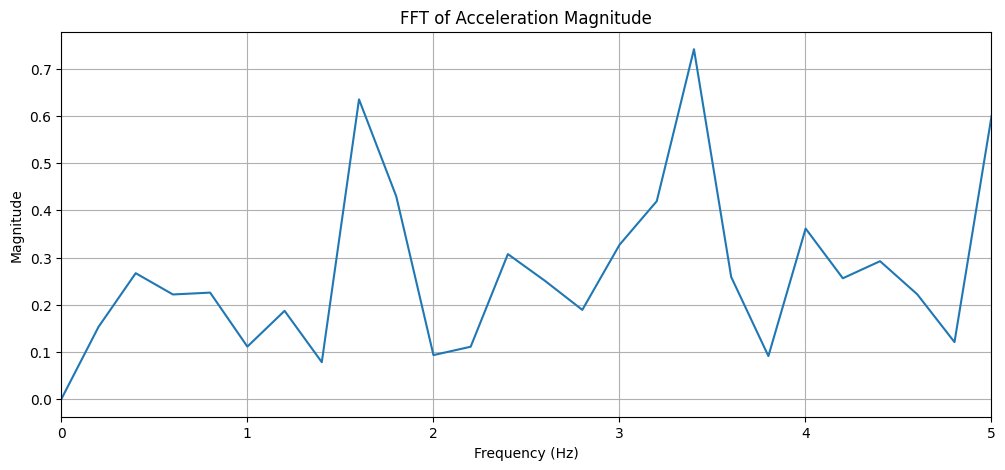

In [24]:
def fft_step_frequency(selected):
    t = selected["Time (s)"].values
    amag = selected["amag"].values

    dt = np.mean(np.diff(t))
    N = len(amag)

    # Remove DC component
    amag = amag - np.mean(amag)

    Y = fft(amag)
    Y_mag = 2.0/N * np.abs(Y[:N//2])
    freqs = fftfreq(N, dt)[:N//2]

    # Focus on human step frequencies
    valid = (freqs >= 0.5) & (freqs <= 5.0)
    dominant_freq = freqs[valid][np.argmax(Y_mag[valid])]

    print(f"Dominant frequency from FFT: {dominant_freq:.2f} Hz ({dominant_freq*60:.0f} steps/min)")

    plt.figure(figsize=(12,5))
    plt.plot(freqs, Y_mag)
    plt.xlim(0, 5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("FFT of Acceleration Magnitude")
    plt.grid(True)
    plt.show()

    return dominant_freq



selected = df[(df["Time (s)"] >= t_start) & (df["Time (s)"] <= t_end)].copy()
selected["amag"] = np.sqrt(
    selected["Linear Acceleration x (m/s^2)"]**2 +
    selected["Linear Acceleration y (m/s^2)"]**2 +
    selected["Linear Acceleration z (m/s^2)"]**2
)
dominant_freq = fft_step_frequency(selected)


According to the FFT, the frequency is 2.40 Hz. This does not align with our manualy found step frequency. The FFT is rougly 2 times larger. We think that this inconsistency is caused because FFT detects step harmonics, not steps. The magnitude sqrt(ax² + ay² + az²) creates two peaks per step in many cases: heel strike
and push-off. 
- Manual peak detection → step frequency
- FFT → impact frequency (≈ 2× step frequency)

This is why we can devide the FFT by two to get the accurate frequency which is: 3.4 / 2 = 1.7. This aligns with our manually found step frequency.

In [12]:
%reset -f

## Task 2: Elevator

For the second task, we have to characterize the traveling velocity, floor height, and to estimate the power output of the motor of an elevator. We took interest in the lift of the apartment building Gloria lives in because she takes it every day. The main things we work out in this task are:
1. Import the data into a pandas dataframe and plotting the acceleration, velocity, and position of the elevator over time
2. Characterize various aspects of the elevator
3. Difference with heavier load

#### 2.0 Importing all relevant python librabies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

#### 2.1 Import the data into a pandas dataframe and plotting the acceleration, velocity, and position of the elevator over time


1. Acceleration
- Data source: The raw vertical acceleration (Acceleration z) measured by your phone’s accelerometer.
- Gravity correction: The raw accelerometer includes gravity (≈ 9.81 m/s²). To get actual elevator acceleration, we subtract the gravitational component.
- How gravity is estimated: We assume the elevator is stationary in the first second (t < 1.0 s). The mean acceleration during this period approximates the local 
gravitational acceleration g.
- Resulting a: This is the true elevator acceleration over time, used for plotting.
2. Velocity
- Data source: a, the acceleration obtained in the previous step.
- Integration: Velocity is the integral of acceleration over time: v(t) = ∫ a(t) dt
- Technique used: scipy.integrate.cumulative_trapezoid performs cumulative trapezoidal integration, giving velocity as a function of time rather than just the total change.
- Drift correction: Numerical integration can accumulate small errors (drift). We subtract a linear trend so that the final velocity returns to zero (elevator stops at the last floor).
3. Position
- Data source: v, the velocity computed in the previous step.
- Integration: Position is the integral of velocity over time: v(t) = ∫ a(t) dt
- Technique used: Again, cumulative_trapezoid for cumulative integration over time, giving position as a function of time.
- Resulting x: Represents elevator height above starting floor at each time step.

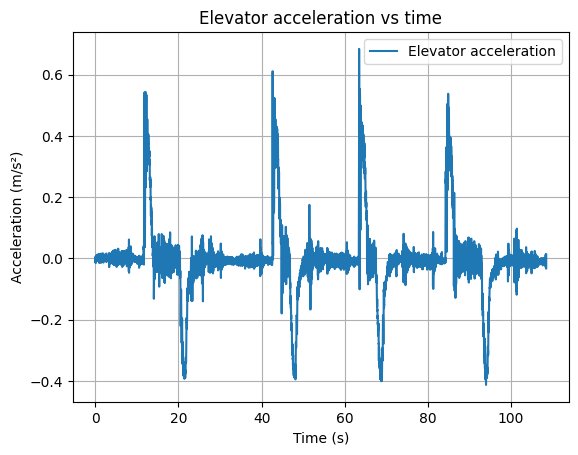

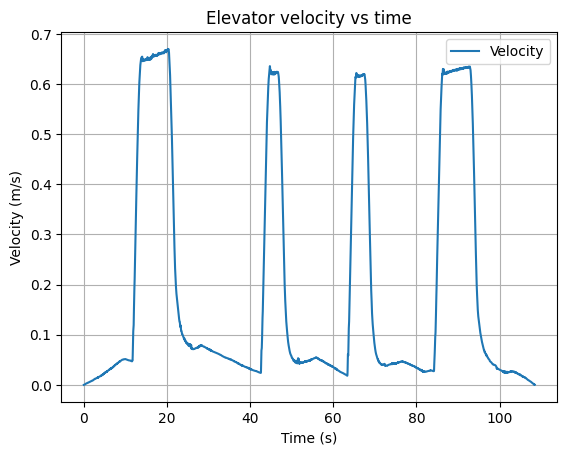

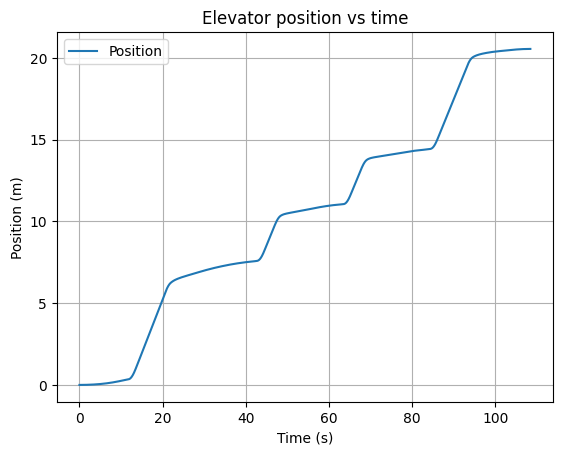

In [ ]:
# Import data into pandas dataframe
df = pd.read_csv(
    "Lift_0_2_3_4_6.csv",
    sep=",",
    decimal=",", # important: comma decimal separator
    quotechar='"'
)

df = df.apply(pd.to_numeric, errors="coerce") # Convert all columns to float (safe cleanup)


# Plot acceleration
t = df["Time (s)"].values
az = df["Acceleration z (m/s^2)"].values

g = np.mean(az[t < 1.0]) # Estimate gravity from stationary part (first second)
a = az - g # Elevator acceleration (remove gravity)

plt.figure()
plt.plot(t, a, label="Elevator acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Elevator acceleration vs time")
plt.grid()
plt.legend()
plt.show()



# Plot velocity
v = cumulative_trapezoid(a, t, initial=0)
v -= np.linspace(0, v[-1], len(v))

plt.figure()
plt.plot(t, v, label="Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Elevator velocity vs time")
plt.grid()
plt.legend()
plt.show()

# position of elevator over time
x = cumulative_trapezoid(v, t, initial=0)

plt.figure()
plt.plot(t, x, label="Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Elevator position vs time")
plt.grid()
plt.legend()
plt.show()

1. Acceleration:
The elevator shows sharp acceleration peaks at start and stop, indicating motor-controlled motion, while the acceleration remains near zero during cruising, reflecting constant speed and smooth, comfort-oriented operation.
2. Velocity:
Velocity rises linearly during the acceleration phase, reaches a plateau during cruising, and decreases symmetrically during braking, illustrating controlled start and stop.
3. Position
Position increases steadily with time, showing upward travel; small slope changes correspond to stops at intermediate floors, and the total displacement matches the overall vertical distance traveled.

#### 2.2 Characterize various aspects of the elevator

In this part, we will calculate various aspects of the elevator like: the Total travel time, Total vertical displacement, Maximum velocity, Mean cruising velocity, Mean motor power, Peak motor power

In [11]:
# Characterize drive
m = 75  # The total mass in the elevator

travel_time = t[-1] - t[0]
total_height = x[-1]
max_speed = np.max(v)
mean_speed = np.mean(v[v > 0.05])  # ignore near-zero values

# Power: P = m (g + a) v
P = m * (g + a) * v

peak_power = np.max(P)

print("\n--- Elevator Drive Characterization ---")
print(f"Total travel time: {travel_time:.2f} s")
print(f"Total vertical displacement: {total_height:.2f} m")
print(f"Maximum velocity: {max_speed:.2f} m/s")
print(f"Mean cruising velocity: {mean_speed:.2f} m/s")

print("\n--- Motor Power ---")
print(f"Mean motor power: {np.mean(P[P > 0]):.1f} W")
print(f"Peak motor power: {peak_power:.1f} W")


--- Elevator Drive Characterization ---
Total travel time: 108.46 s
Total vertical displacement: 20.55 m
Maximum velocity: 0.67 m/s
Mean cruising velocity: 0.34 m/s

--- Motor Power ---
Mean motor power: 139.0 W
Peak motor power: 492.2 W


#### 2.3 Difference with heavier load
For a heavier load inside the elevator, the acceleration and velocity profiles are expected to remain largely unchanged, since elevator motion is primarily constrained by passenger comfort and safety requirements. However, the motor force required to lift the elevator increases with the total mass. As a result, the motor power, given by 
𝑃 = 𝑚(𝑔 + 𝑎)𝑣, scales approximately linearly with the load mass. This leads to a higher average and peak motor power for heavier loads, while the travel time and maximum velocity remain approximately constant. Consequently, heavier loads place greater mechanical and electrical demand on the elevator motor without significantly altering the overall motion profile.